Project Background:

Breast cancer remains one of the most common and impactful cancers worldwide - especially for women. Early and accurate diagnosis can significantly enhance treatment outcomes. Leveraging machine learning techniques can aid in this by providing predictive insights and visualizations that enhance the understanding of cancer classification based on histopathological data.

In this project, I will develop a machine learning-based tool that aids in the diagnosis and visualization of breast cancer types from biopsy data. I will be using the Breast Cancer Dataset from UCI. The tool will employ K-means clustering on PCA-reduced data, logistic regression, and anomaly detection with the Isolation Forest algorithm. These techniques will help in identifying patterns, classifying data, and detecting potential outliers or rare cases in the dataset.

## Dataset from UCI Machine Learning Repository

[Breast Cancer Wisconsin (Diagnostic) Data Set from UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29)


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import requests
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeClassifier, Lasso, ElasticNet, RidgeClassifierCV, LassoCV, ElasticNetCV

In [105]:
#load the data
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data"
df = pd.read_csv(url, header = None) 

In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       699 non-null    int64 
 1   1       699 non-null    int64 
 2   2       699 non-null    int64 
 3   3       699 non-null    int64 
 4   4       699 non-null    int64 
 5   5       699 non-null    int64 
 6   6       699 non-null    object
 7   7       699 non-null    int64 
 8   8       699 non-null    int64 
 9   9       699 non-null    int64 
 10  10      699 non-null    int64 
dtypes: int64(10), object(1)
memory usage: 60.2+ KB


The UCI dataset, as observed above, does not contain labels. Therefore, we need to collect and add these labels separately, which will indicate whether a particular sample is benign or malignant along with its feature labels.

In [107]:
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.names"
response = requests.get(url)

df_data_description = response.text.splitlines()

In [108]:
df_data_description[0:5]

['Citation Request:',
 '   This breast cancer databases was obtained from the University of Wisconsin',
 '   Hospitals, Madison from Dr. William H. Wolberg.  If you publish results',
 '   when using this database, then please include this information in your',
 '   acknowledgements.  Also, please cite one or more of:']

In [109]:
selected_lines = df_data_description[105:116]
selected_lines
#we retrieve the labels

['   1. Sample code number            id number',
 '   2. Clump Thickness               1 - 10',
 '   3. Uniformity of Cell Size       1 - 10',
 '   4. Uniformity of Cell Shape      1 - 10',
 '   5. Marginal Adhesion             1 - 10',
 '   6. Single Epithelial Cell Size   1 - 10',
 '   7. Bare Nuclei                   1 - 10',
 '   8. Bland Chromatin               1 - 10',
 '   9. Normal Nucleoli               1 - 10',
 '  10. Mitoses                       1 - 10',
 '  11. Class:                        (2 for benign, 4 for malignant)']

In [110]:
df_col_names = [re.sub(r".*[0-9]\. ", "", line) for line in selected_lines]
df_col_names

['Sample code number            id number',
 'Clump Thickness               1 - 10',
 'Uniformity of Cell Size       1 - 10',
 'Uniformity of Cell Shape      1 - 10',
 'Marginal Adhesion             1 - 10',
 'Single Epithelial Cell Size   1 - 10',
 'Bare Nuclei                   1 - 10',
 'Bland Chromatin               1 - 10',
 'Normal Nucleoli               1 - 10',
 'Mitoses                       1 - 10',
 'Class:                        (2 for benign, 4 for malignant)']

In [111]:
#removes any test after three spaces in df_col_names
df_col_names = [name.split("   ")[0] for name in df_col_names]
df_col_names

['Sample code number',
 'Clump Thickness',
 'Uniformity of Cell Size',
 'Uniformity of Cell Shape',
 'Marginal Adhesion',
 'Single Epithelial Cell Size',
 'Bare Nuclei',
 'Bland Chromatin',
 'Normal Nucleoli',
 'Mitoses',
 'Class:']

In [112]:
def make_name(s):
    # replace invalid characters with underscores
    s = re.sub(r"[^a-zA-Z0-9_]", "_", s)
    # not starting with a digit
    s = re.sub(r"^[0-9]", "_", s)
    return s
df_col_names = [make_name(name) for name in df_col_names]
df_col_names
df.columns = df_col_names

Now, we have our modified column names which we can now add to our dataframe df

In [113]:
df.columns

Index(['Sample_code_number', 'Clump_Thickness', 'Uniformity_of_Cell_Size',
       'Uniformity_of_Cell_Shape', 'Marginal_Adhesion',
       'Single_Epithelial_Cell_Size', 'Bare_Nuclei', 'Bland_Chromatin',
       'Normal_Nucleoli', 'Mitoses', 'Class_'],
      dtype='object')

In [114]:
df = df.rename(columns={"Class_": "Class"})
df.dtypes

Sample_code_number              int64
Clump_Thickness                 int64
Uniformity_of_Cell_Size         int64
Uniformity_of_Cell_Shape        int64
Marginal_Adhesion               int64
Single_Epithelial_Cell_Size     int64
Bare_Nuclei                    object
Bland_Chromatin                 int64
Normal_Nucleoli                 int64
Mitoses                         int64
Class                           int64
dtype: object

In [115]:
df['Sample_code_number'] = df['Sample_code_number'].astype(str)

Since bare nuclei is a string, we will convert it into numerical format. Below, we comvert the "Class" column into a categorical data type. We will use 'coerce' to convert non-numerical values to NAN.

In [116]:
df['Class'] = pd.Categorical(df['Class'])
df['Class'] = df['Class'].cat.codes.replace({2: 0, 4: 1})

In [117]:
df['Bare_Nuclei'] = pd.to_numeric(df['Bare_Nuclei'], errors='coerce')


In [118]:
df = df.dropna()
#drop NAN values

In [119]:
df.describe()

,Clump_Thickness,Uniformity_of_Cell_Size,Uniformity_of_Cell_Shape,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class
count,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000
mean,4.442167,3.150805,3.215227,2.830161,3.234261,3.544656,3.445095,2.869693,1.603221,0.349927
std,2.820761,3.065145,2.988581,2.864562,2.223085,3.643857,2.449697,3.052666,1.732674,0.477296
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,0.000000
50%,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,0.000000
75%,6.000000,5.000000,5.000000,4.000000,4.000000,6.000000,5.000000,4.000000,1.000000,1.000000
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000


The statistical summary tells us that:
Each column has 699 entries, which means the dataset consists of 699 samples or observations.
The `Class` mean is approximately 0.34, suggesting that the dataset might be imbalanced, with more samples of one class than the other.
All the features range from 1 to 10, and the `Class` variable ranges from 0 to 1.

From this summary, we can inefer that the features have different ranges (1-10), but they are all numerical. The `Class` variable is binary (0-1), suggesting a classification problem. The differences in the mean values and standard deviations suggest that some features may have more influence on the `Class` outcome than others.

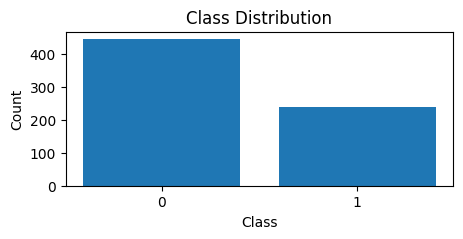

In [126]:
import matplotlib.pyplot as plt
#counter of class
class_counts = df['Class'].value_counts()


plt.figure(figsize=(5, 2))
plt.bar(['0', '1'], class_counts.values)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

Above, we have visualized the distribution of classes within the dataset, and see there are more cases of benign (0) then malignant(1).  We are now going to perform some Data Preprocessing, where we normalize the data and split it into training and testing sets. Normalization ensures that all features have a similar scale, reducing bias in the model. We will apply these preprocessing steps to our dataset before training the ML models.
We will utilize the `train_test_split` and `StandardScaler` functions from the `sklearn.preprocessing` module in Sklearn :


In [121]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separate features and target, drop class from X 
X = df.drop('Class', axis=1)
y = df['Class']

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split df into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

Now that we have defined our training and test sets, we will move forward to apply some ML techniques.
There is the phrase "curse of dimensionality" in Machine learning, where datasets with a high number of features can lead to more complex models that are prone to overfitting and are computationally expensive to train. PCA directly addresses this by transforming the dataset into a lower-dimensional space, thus reducing the feature set to the most informative components. 
When the input data is transformed into principal components, the information is effectively compressed while still maintaining the patterns and structures necessary for learning.

In breast cancer diagnosis, the goal is to accurately classify tumors as benign or malignant based on features derived from cell images. These features may include aspects like uniformity of cell size, clump thickness, and others that can be numerous and highly correlated. Therefore, we will use PCA to address "the curse od dimensionality" and use it as a technique to reduce dimensionality and transform our variables into an smaller yet valuable dataset.

In [122]:
from sklearn.decomposition import PCA

# Applying PCA
pca = PCA(n_components=2)  # Reducing to 2 dimensions 
X_pca = pca.fit_transform(X_scaled)

# create X_pca_df so we can store our data and use later
X_pca_df = pd.DataFrame(data = X_pca, columns = ['Principal Component 1', 'Principal Component 2'])


Now that we have applied PCA to our breast cancer dataset, we will use k-means culstering. K means is an unsupervised learning algorithm that groups similar points together. This happens by identifying k number of centroids. 
We will use K means to group PCA transformed data into two clusters (benign and malignant). 

The goal is to see how well our PCA - transformed model can distinguish between the two binary classes.

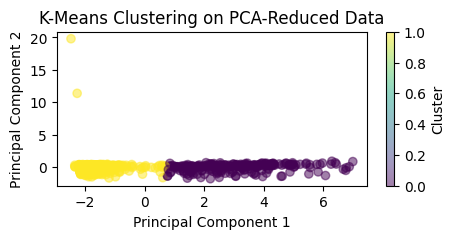

In [124]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# K-means clustering on the PCA results
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_pca_df)

plt.figure(figsize=(5, 2))
scatter = plt.scatter(X_pca_df['Principal Component 1'], X_pca_df['Principal Component 2'], c=clusters, cmap='viridis', alpha=0.5)
cbar = plt.colorbar(scatter)
cbar.set_label('Cluster')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-Means Clustering on PCA-Reduced Data')
plt.show()

The K-Means Clustering on PCA-Reduced data plot generates a two dimensional view of the breast cancer dataset. The model shows two clusters (yellow) (purple) that are identifiable, which correspond to benign and malignant breast tumors. Principal component 1 captures most of the variance of the data, which could mean that the original variables are highly correlated and can be captured in a single principal component. We can also see some outliers along principal component 1. 

The plot shows that the PCA-Reduced model does identify classes accurately - we will now code a scree plot to identify the optimal number of clusters.

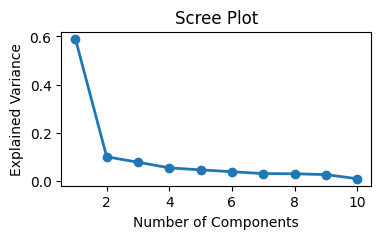

In [125]:
import matplotlib.pyplot as plt
pca = PCA()
pca.fit(X_scaled)

# Get the explained variance
explained_variance = pca.explained_variance_ratio_

plt.figure(figsize=(4, 2))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, 'o-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.show()

Based on the scree plot, we select K=2 clusters. This choice corresponds to the 'elbow' point in the curve, where it starts to level off, indicating that two is the optimal number of components. Having applied K-means clustering on the PCA-reduced data, we will now proceed with logistic regression.

Logistic regression is a machine learning algorithm used for binary classification problems, like ours, where the goal is to distinguish between benign and malignant tumors. It works by modeling the probability that a given sample belongs to a particular class.

In the context of our project, applying logistic regression to the PCA-reduced and K-means clustered data allows us to create a model that can predict the likelihood of a tumor being benign or malignant based on its features. This is crucial for diagnosing breast cancer and could potentially aid in early detection and treatment planning.

In [91]:
from sklearn.linear_model import LogisticRegression

# Create a logistic regression model
model = LogisticRegression()
#train the model
model.fit(X_train, y_train)

LogisticRegression()

We want to evaluate the performance on the test set (X_test) to make predictions, after training the model on the train set (X_train) (y_train). 

In [92]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test)
# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)

print(f"Model accuracy: {accuracy}")

Model accuracy: 0.9562043795620438


In [94]:
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

# sensitivity and specificity
sensitivity = conf_matrix[1, 1] / (conf_matrix[1, 1] + conf_matrix[1, 0])
specificity = conf_matrix[0, 0] / (conf_matrix[0, 0] + conf_matrix[0, 1])

print(f"Sensitivity: {sensitivity:.2f}")
print(f"Specificity: {specificity:.2f}")


[[78  1]
 [ 5 53]]
Sensitivity: 0.91
Specificity: 0.99


The confusion matrix, [[78, 1], [5, 53]], which tells us that the number of true negatives (78), false positives (1), false negatives (5) and true positives (53).

Our model has an accuracy of approximately 95.6%, meaning it correctly predicted the tumor class (benign or malignant) for about 95.6% of the samples in the test set. This high accuracy indicates that our model is quite reliable.

 The model's sensitivity is 0.91, implying that it correctly identified 91% of the malignant cases. This is crucial in a medical diagnosis context, as a high sensitivity reduces the chances of false negatives, thus ensuring malignant tumors are correctly identified for treatment.

 With a specificity of 0.99, the model correctly identified 99% of the benign cases. This is equally important as it minimizes the chances of false positives, reducing the risk of unnecessary medical procedures for patients.


In the context of my project, these metrics suggest that the model, trained on PCA-reduced and K-means clustered data, performs well in distinguishing between benign and malignant breast cancer tumors. This could potentially be a valuable tool for aiding early detection and treatment planning in breast cancer.

We have now created a predictive model that can be used to classify new, unseen tumours.
Now, to ensure our model is robust, and not just performing well on a particular part of the data, we will apply cross validation and evaluate performance across different folds. This will give us a better idea of how the model will perform when it is used to make predictions on new data in the future. 

Cross Validation is a machine learning technique used to estimate the performance of the model - we will ensure that every observation from the original dataset has the chance of appearing in training/test set.

Cross-validation score: 0.9649098325461573
Accuracies for each fold are: [0.93430657 0.94160584 0.98540146 0.97794118 0.98529412]


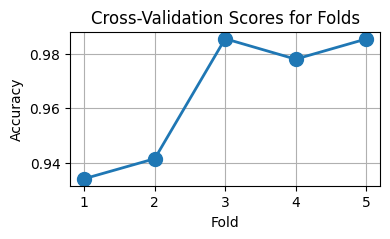

In [97]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

# Create a StratifiedKFold 
stratified_kfold = StratifiedKFold(n_splits=5)
scores = cross_val_score(model, X_scaled, y, cv=stratified_kfold)
# mean score
print(f"Cross-validation score: {scores.mean()}")
# accuracy of each fold
print(f'Accuracies for each fold are: {scores}')
plt.figure(figsize=(4, 2))
plt.plot(range(1, len(scores) + 1), scores, 'o-', linewidth=2, markersize=10)
plt.title('Cross-Validation Scores for Folds')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.xticks(range(1, len(scores) + 1))
plt.grid(True)
plt.show()

The cross-validation scores represent the accuracy of the models on each of the 5 folds, therefore our model's ability to generalize to unseen data is high. The accuracy is approx 96.5 % increasing from the logsitic regression score of 95.63%. The plot above shows the high Cross-Validation Scores along all five folds. 

Fiaally, I will implement Risk Factor Analysis by using Isolation Forest from Sklearn by exploring the dataset to identify risk factors associated with breast cancer. 
In this case, I want to create a simple but effective Anomaly detection tool that can help identify possible rare or agressive forms of cancer. The anomalies detected by the IsolationForest could possibly be those cases.

Isolation Forest is an unsupervised learning algorithm for anomaly detection. It is useful for detecting outliers - in this case rare or aggressive forms of breast cancer. 
This represents a vital aspect of my project: serving as a detection tool following the rigorous application of machine learning techniques to ensure our model's robustness and accuracy.

In [98]:
from sklearn.ensemble import IsolationForest
iso_forest = IsolationForest(n_estimators=100)
#predict outliers
outliers = iso_forest.fit_predict(X_scaled)
X_pca_df['outlier'] = outliers

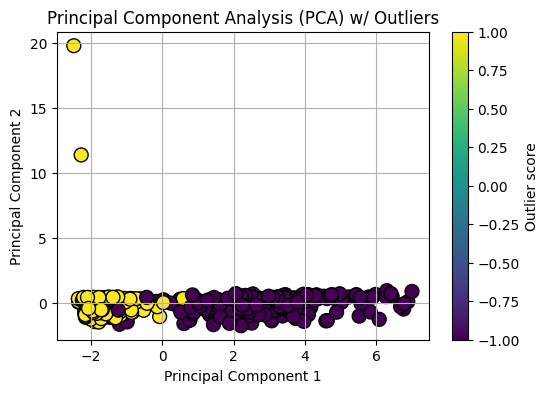

In [104]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))  #
plt.scatter(X_pca_df['Principal Component 1'], X_pca_df['Principal Component 2'], 
            c=X_pca_df['outlier'], edgecolor='k', s=100, cmap='viridis')  
plt.colorbar(label='Outlier score') 
plt.xlabel('Principal Component 1')  
plt.ylabel('Principal Component 2')  
plt.title('Principal Component Analysis (PCA) w/ Outliers')  
plt.grid(True)  
plt.show()

The plot distinctly displays outliers and anomalies. (the purple dots on the yellow cluster is an example of an anomaly which our Detection tool produces) 

In [100]:
print(X_pca_df['outlier'].value_counts())

outlier
 1    434
-1    249
Name: count, dtype: int64


The IsolationForest returns -1 for anomalies and 1 for normal data points. We see there are 434 cases of normal cancer and 249 possible cases of agressive or rare cancer. 

In [103]:
counts = X_pca_df['outlier'].value_counts()

print(f"There are {counts[1]} normal cases.")
print(f"There are {counts[-1]} potential cases of rare or aggressive cancer.")

There are 434 normal cases.
There are 249 potential cases of rare or aggressive cancer.


The count of anomalous cases gives a clear idea of how many instances in the dataset are considered outliers by the Isolation Forest algorithm. These are cases that deviate significantly from the norm based on the underlying feature space reduced by PCA. Such deviations might correspond to rare or aggressive forms of breast cancer.
By flagging these anomalies, my diagnostic tool can provide oncologists with alerts to potentially identify serious forms of cancer. By possibly catching these cases earlier, this tool can be useful in routine screenings where such anomalies might go unnoticed.

## Conclusion

The Breast Cancer Diagnostic Assistant project leveraged machine learning techniques to enhance diagnostic accuracy and predictive capabilties. Using the tried and true Breast Cancer Wisconsion dataset, this project employed ML techniques Principal component Analysis (PCA) to reduce the dimensionality of the data, therfore simplifying the feature set but still retaining important information for analysis.

By applying k-means clustering on the PCA reduced data, we 
identified distinct groups of the data, which gave insight into the variance of the data. (benign and malignant)

The logistic regression model demonstrated high accuracy, sensitivity, and specificity, indicating its effectiveness in classifying tumors as benign or malignant. This metric is really important especially in medical diagnostics, where the cost of false negatives can be fatal.

Finally, an anomaly detection component was implemented using the Isolation Forest algorithm. This method identified outliers within the data - flagging potential rare or aggressive forms of cancer.

Overall, the Breast Cancer Diagnostic Assistant serves as a prototype for how ML can be applied to medical diagnostics, and provides a highly accurate model as a tool for aiding in early detection and classification of breast cancer. 

This project has been a great learning experience, particularly in applying machine learning techniques to real-world contexts. My passion for this tool stems from its potential impact, given the widespread effect of breast cancer on women globally. 
